In [1]:
#Code by David Roberts https://www.kaggle.com/code/davidbroberts/tensorflow-transfer-learning/notebook

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Set the log level to keep the warnings down

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from lib.datasets.datasets import BinMazeDataset
from tqdm import tqdm
from lib.datasets.datasets import get_maze_data
from torch.utils.data import Dataset, DataLoader
import torchvision
from config.config_hollow_maze import get_config 
from lib.datasets.maze import maze_gen
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt

# Eine Funktion, um einige Bilder zu plotten
def show_images(images, n=8):
    plt.figure(figsize=(15, 15))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy().astype("uint8"), cmap='gray')
        plt.axis("off")
    plt.show()

In [11]:
for i in range(3 -1):
    print(i)
    if i != (3-2):
        print("act")

0
act
1


In [5]:
config = get_config()
img = maze_gen(limit=10, dim_x=7, dim_y=7, pixelSizeOfTile=2, weightHigh=97,weightLow=97)
torch_dataloader = get_maze_data(config, img)

In [6]:
for i in tqdm(torch_dataloader):
    print(i, i.shape)
    break

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[[[0, 0, 1,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 1, 0, 0],
          ...,
          [0, 0, 1,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 1, 0, 0]]],


        [[[0, 0, 1,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 1, 0, 0],
          ...,
          [0, 0, 1,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 1, 0, 0]]],


        [[[0, 0, 1,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 1, 0, 0],
          ...,
          [0, 0, 1,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 1, 0, 0]]],


        ...,


        [[[0, 0, 1,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 1, 0, 0],
          ...,
          [0, 0, 1,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 1, 0, 0]]],


        [[[0, 0, 1,  ..., 0, 0, 0],
         

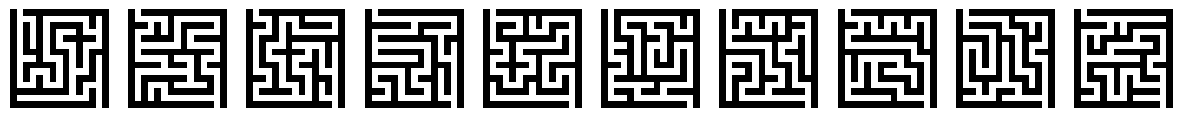

In [7]:


# Nehmen Sie einen Batch von Bildern
images = next(iter(torch_dataloader))
show_images(images * 255, n=10)